## Df + Lib

In [1]:
# df that have:
# user as numeric feature (from 0 to 5) 
# maingenre as numeric feature (from 0 to 16) --> tot 17 maingenri  
%store -r merge_unique_numain_df

In [2]:
# package that we need
import keras
from keras.models import Sequential
# we most use sequential model -> one layer after the other (sequence of layer)
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import MeanAbsolutePercentageError

#for the CROSS-VALIDATION
from sklearn.model_selection import KFold

# essential
import numpy as np
import matplotlib.pyplot as plt

# not necessary in this case
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error

## CROSS VALIDATION 

we want to try this approach in order to optimize our recomandation system, more in detail our NN

### TEST USER 1

In [3]:
# as a preliminary test in order to better understand cross validation, i try to develop it only for the user1
mask_u1=merge_unique_numain_df['User']==1
u1_df=merge_unique_numain_df[mask_u1]
u1_df.shape

(4669, 21)

In [4]:
#u1_df.isnull().sum()
# since we don't have null values we can procede in dividing the df

# TARGET_var
target='valence'

#FEATURES
features=[    'spotify_track_duration_minute', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'tempo', 'time_signature',
    'spotify_track_popularity', 'instrumentalness', 'liveness']

In [5]:
# now we can optain our variable x and y 

# TARGET
y=u1_df[target]

# FEATURES
x=u1_df[features]

In [6]:
# we need to standardize our features

# Standardizzazione delle feature
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [7]:
# Definition of the parameters of the kfold cross-validation
# the folds are generally 5 or 10 
# the folds indicate in wich part we divide the df, each folds have a similar dimension 
# in this way:

#Run k iterations of training and validation:

#Iteration 1: Trained on Fold 2-3-4-5, valid on Fold 1
#Iteration 2: Trained on Fold 1-3-4-5, valid on Fold 2
#And so on, until you have used each fold as a validation set once.

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [8]:
# now we can define a function in order to build our NN

def create_model():
        model = Sequential()
        model.add(Dense(32, activation='relu', input_shape=(x_scaled.shape[1],)))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(1))  # Output --> valence
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse',metrics=['mae'])
        return model

In [9]:
# we define a list in order to save the error for each fold
mse_scores=[]

In [10]:
# now we have to divide the df in train and test, following the cross validatin process
for train_index, val_index in kf.split(x_scaled):
    X_train, X_val = x_scaled[train_index], x_scaled[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

In [11]:
# now we can build and create the model
model_u1 = create_model()
h_model_u1=model_u1.fit(X_train, y_train, epochs=20,validation_split=0.2, batch_size=32, verbose=0)

c:\Users\lovoa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model_u1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,981 (11.65 KB)

 Trainable params: 993 (3.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,988 (7.77 KB)

In [13]:
#evaluation of the model
y_pred = model_u1.predict(X_val).flatten()
mse = mean_squared_error(y_val, y_pred)
mse_scores.append(mse)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [14]:
# Calcolo della media e deviazione standard del MSE
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

print(f'MSE medio: {mean_mse:.4f}')
print(f'Deviazione standard del MSE: {std_mse:.4f}')

MSE medio: 0.0327
Deviazione standard del MSE: 0.0000


This is the result of the mae that we obtain from the 'basic' methond **train/test split**

MSE user1: 0.03147273977545834 

We don't see significant improvements from a MSE pov, this is normal because the real **AIM of this procedure** is to obtain estimation that are **more robust**, so we don't have to evaluete the result of this metrics in order to compare the two method.

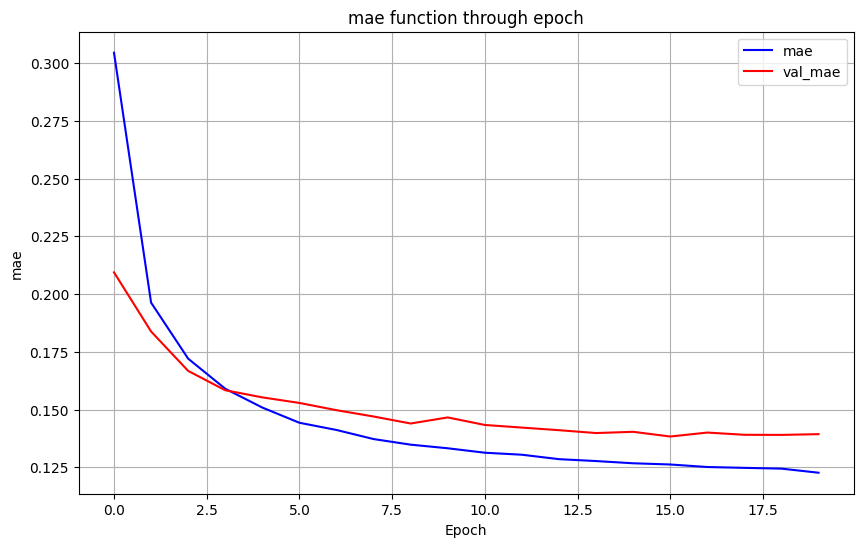

In [15]:
# we can try to perform some plots
plt.figure(figsize=(10,6))
plt.plot(h_model_u1.history['mae'],color='blue',label='mae')
plt.plot(h_model_u1.history['val_mae'],color='red',label='val_mae')
plt.xlabel('Epoch')
plt.ylabel('mae')
plt.title('mae function through epoch')
plt.legend()
plt.grid()
plt.show()

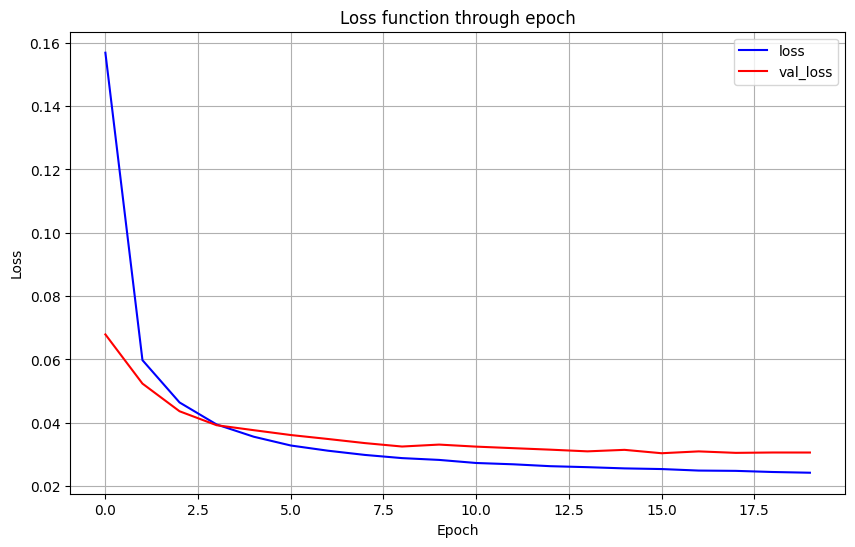

In [16]:
plt.figure(figsize=(10,6))
plt.plot(h_model_u1.history['loss'],color='blue',label='loss')
plt.plot(h_model_u1.history['val_loss'],color='red',label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss function through epoch')
plt.legend()
plt.grid()
plt.show()

### So, how can we evaluate if one method is better that the other ?

1) Evaluate the std, if the std is lesser, this means that our esimation is better than the other since we have less oscillation 

2) Metrics (mse, mae)

3) Statistics test 

4) Learning rate

In [17]:
# if we look at the std for example in the model with the cross validation, we see:
print(f'MSE medio: {mean_mse:.4f}')
print(f'Deviazione standard del MSE: {std_mse:.4f}') 

# we have 0 std --> WE HAVE TO CHECK IT ALSO FROM THE STANDARD METHOD IN THE NN FILE

MSE medio: 0.0327
Deviazione standard del MSE: 0.0000


## GENARALIZE CRSS VALIDATION - all users

In [18]:
# TARGET_var
target='valence'

#FEATURES
features=[    'spotify_track_duration_minute', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'tempo', 'time_signature',
    'spotify_track_popularity', 'instrumentalness', 'liveness']

### DEFINE FUNCTIONS

In [19]:
####################
### CREATE MODEL ###
####################


# function to create the model
def create_model_user(shape_x_train): #number of columns -> shape
    
    
    model_user_i = Sequential([
        Dense(32, input_dim=shape_x_train, activation='relu', name='first_layer'),
        # 64 as the number of initial layer is a common choice when we build a NN --> VEDIAMO COME FUNZIA POI NEL CASO SI SISTEMA IN SEGUITO
        # input_dim: take the dimension of the x_train array --> that is equivalent to the number of feature in input
        
        # SI POSSONO AGGIUNGERE PER OGNI LAYER --> Dropout(0.3) per evitare overfitting
        

        Dense(16, activation='relu', name='secod_layer'),
        Dense(1, activation='linear', name='final_layer')
    ])

    #compile the model
    model_user_i.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])

    #summary
    #display(model_user_i.summary())

    #return  the model
    return model_user_i

#################
### FIT MODEL ###
#################

#function to train the model
def fit_model(model, x_train, y_train, x_test, y_test):

    history_model = model.fit(
        x_train,y_train,
        #validation_split=0.2,
        validation_data = [x_test, y_test],
        epochs=30,
        batch_size=32,
        #verbose=1
    )

    return history_model

############
### PLOT ###
############

def plot_for_model(history, y_hat, x_test):

    #plot loss
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'],color='blue',label='loss')
    plt.plot(history.history['val_loss'],color='red',label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss function through epoch')
    plt.legend()
    plt.grid()
    plt.show()

    #plot mean
    plt.figure(figsize=(10,6))
    plt.plot(history.history['mae'],color='blue',label='mae')
    plt.plot(history.history['val_mae'],color='red',label='val_mae')
    plt.xlabel('Epoch')
    plt.ylabel('mae')
    plt.title('Mae function through epoch')
    plt.grid()
    plt.legend()
    plt.show()   

    # plot 
    # aggiunto A.L
    plt.figure(figsize=(12,6))
    plt.plot(y_test, color='r')
    plt.plot(y_hat, color='b') #attenzione alcune predizione sono negative
    plt.title('Prediction')
    plt.legend()
    plt.show()

### MAIN

Epoch 1/30


c:\Users\lovoa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2663 - mae: 0.4011 - val_loss: 0.0637 - val_mae: 0.2016
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0545 - mae: 0.1852 - val_loss: 0.0481 - val_mae: 0.1731
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0424 - mae: 0.1648 - val_loss: 0.0428 - val_mae: 0.1623
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0363 - mae: 0.1530 - val_loss: 0.0388 - val_mae: 0.1556
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0334 - mae: 0.1456 - val_loss: 0.0365 - val_mae: 0.1522
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0317 - mae: 0.1426 - val_loss: 0.0346 - val_mae: 0.1477
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0297 - mae: 0.1375 - val_loss: 0.0344 - val_mae: 0.1478
Epoch 8/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0290 - mae: 0.1371 - val_loss: 0.0333 - val_mae: 0.1458
Epoch 9/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0291 

,Song,Performer,valence
SongID,,,
...Baby One More TimeBritney Spears,...Baby One More Time,Britney Spears,0.907
(everybody Wanna Get Rich) Rite AwayDr. John,(everybody Wanna Get Rich) Rite Away,Dr. John,0.971
(If You Want It) Do It YourselfGloria Gaynor,(If You Want It) Do It Yourself,Gloria Gaynor,0.729
(Pride) In The Name Of LoveU2,(Pride) In The Name Of Love,U2,0.750
(Sittin' On) The Dock Of The BayOtis Redding,(Sittin' On) The Dock Of The Bay,Otis Redding,0.535
...,...,...,...
Don't Touch MeBettye Swann,Don't Touch Me,Bettye Swann,0.570
"Don't Wake Me Up In The Morning, MichaelPeppermint Rainbow","Don't Wake Me Up In The Morning, Michael",Peppermint Rainbow,0.915
Don't You Know How Much I Love YouRonnie Milsap,Don't You Know How Much I Love You,Ronnie Milsap,0.858


-----------------------------------------------------
---------------------------------------------------------
USER 0


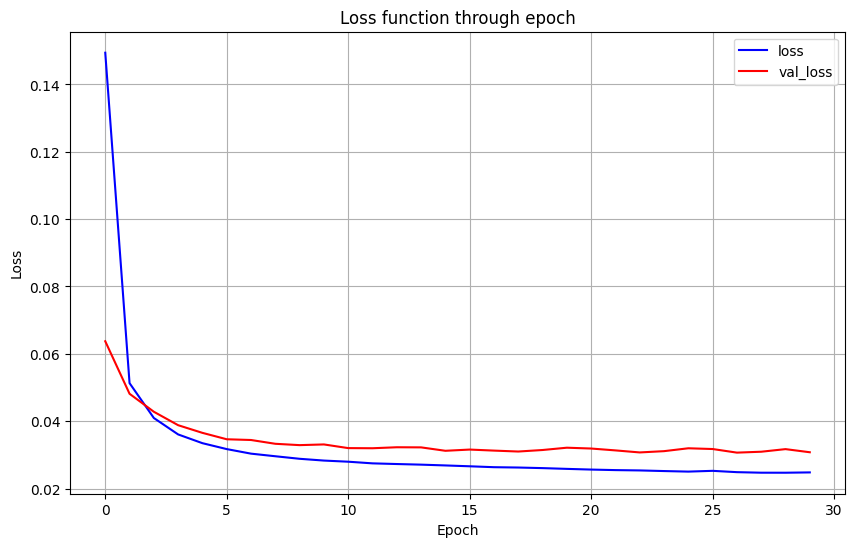

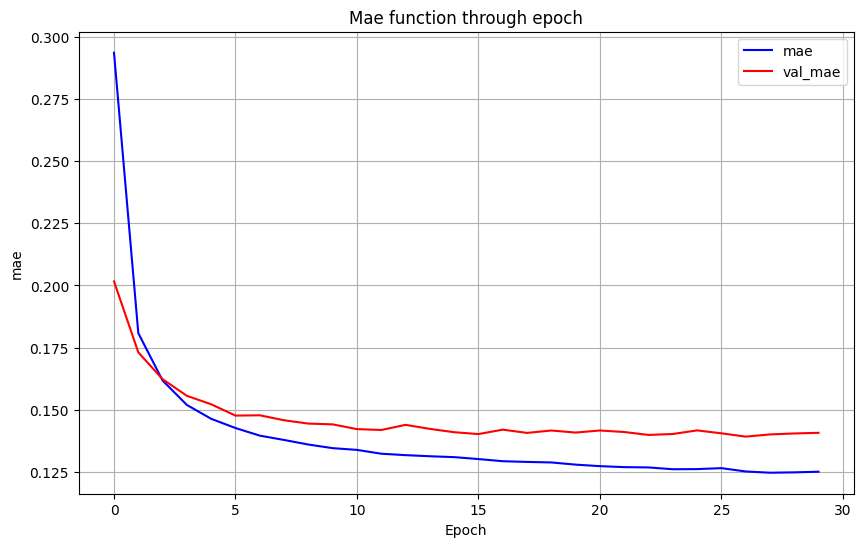

C:\Users\lovoa\AppData\Local\Temp\ipykernel_12568\250368514.py:83: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


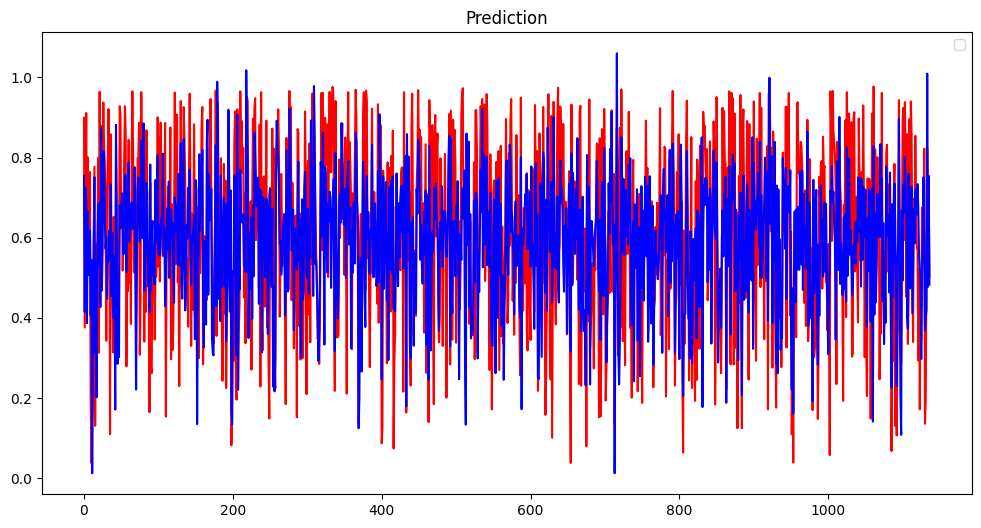

MSE


0.030775893212395208

Epoch 1/30


c:\Users\lovoa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1294 - mae: 0.2838 - val_loss: 0.0625 - val_mae: 0.1881
Epoch 2/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0481 - mae: 0.1754 - val_loss: 0.0485 - val_mae: 0.1671
Epoch 3/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0373 - mae: 0.1532 - val_loss: 0.0415 - val_mae: 0.1562
Epoch 4/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0329 - mae: 0.1434 - val_loss: 0.0382 - val_mae: 0.1503
Epoch 5/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0310 - mae: 0.1405 - val_loss: 0.0370 - val_mae: 0.1476
Epoch 6/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0295 - mae: 0.1357 - val_loss: 0.0365 - val_mae: 0.1473
Epoch 7/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0280 - mae: 0.1331 - val_loss: 0.0345 - val_mae: 0.1433
Epoch 8/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0268 - mae: 0.1312 - val_loss: 0.0336 - val_mae: 0.1421
Epoch 9/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0263 

,Song,Performer,valence
SongID,,,
'Til My Baby Comes HomeLuther Vandross,'Til My Baby Comes Home,Luther Vandross,0.802
(Closest Thing To) PerfectJermaine Jackson,(Closest Thing To) Perfect,Jermaine Jackson,0.905
(I Can't Get No) SatisfactionThe Rolling Stones,(I Can't Get No) Satisfaction,The Rolling Stones,0.904
(I'm Not Your) Steppin' StoneThe Monkees,(I'm Not Your) Steppin' Stone,The Monkees,0.324
(I've Got) Spring FeverLittle Willie John,(I've Got) Spring Fever,Little Willie John,0.730
...,...,...,...
Don't Know What You Got (Till It's Gone)Cinderella,Don't Know What You Got (Till It's Gone),Cinderella,0.232
Don't Let GoIsaac Hayes,Don't Let Go,Isaac Hayes,0.962
Don't Let Him Shop AroundDebbie Dean,Don't Let Him Shop Around,Debbie Dean,0.948


-----------------------------------------------------
---------------------------------------------------------
USER 1


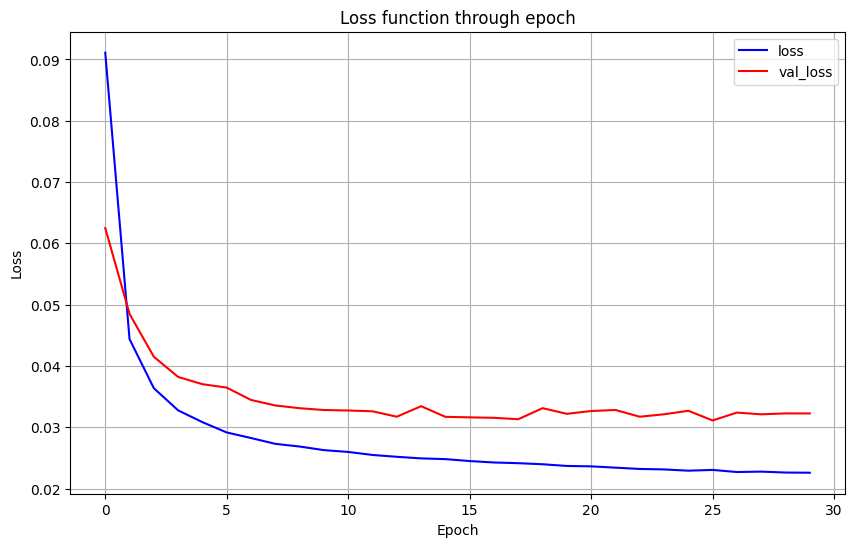

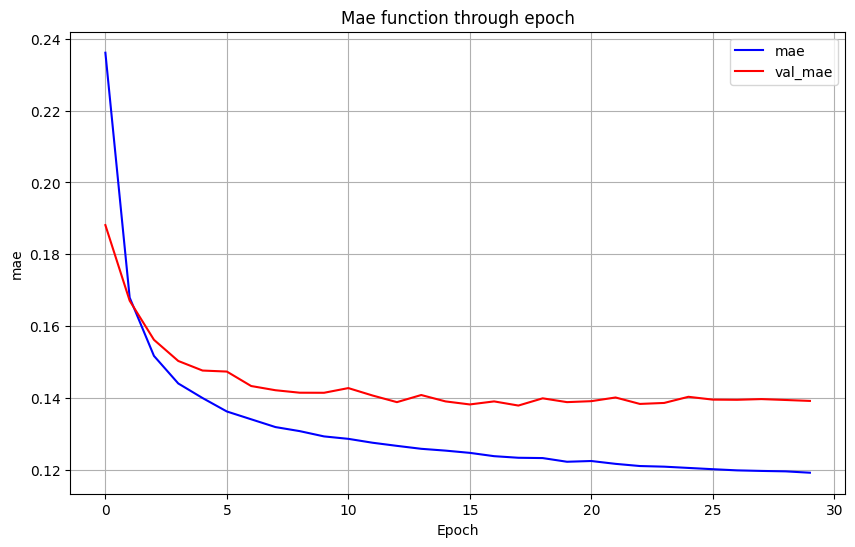

C:\Users\lovoa\AppData\Local\Temp\ipykernel_12568\250368514.py:83: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


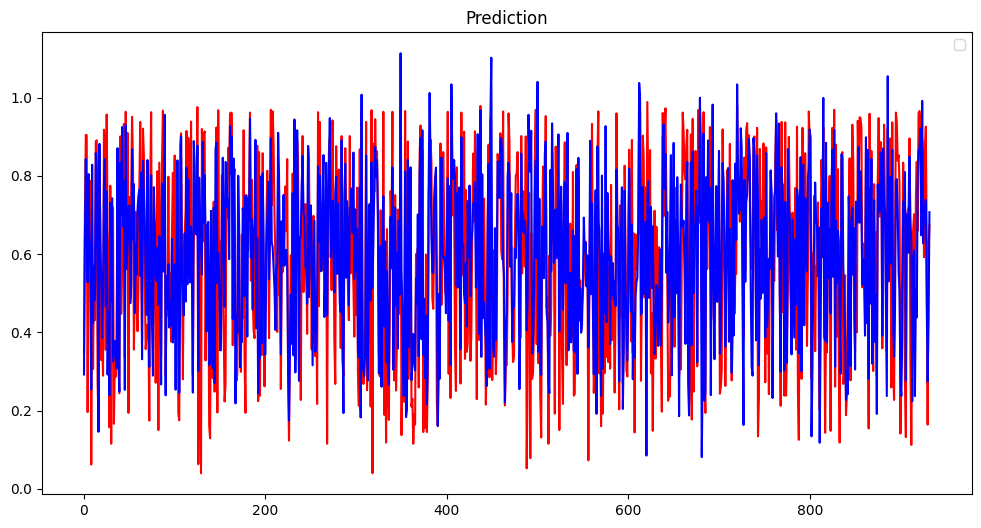

MSE


0.03226687848328848

Epoch 1/30


c:\Users\lovoa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1441 - mae: 0.2920 - val_loss: 0.0335 - val_mae: 0.1327
Epoch 2/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0323 - mae: 0.1290 - val_loss: 0.0256 - val_mae: 0.1107
Epoch 3/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0255 - mae: 0.1102 - val_loss: 0.0231 - val_mae: 0.1020
Epoch 4/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0229 - mae: 0.1031 - val_loss: 0.0213 - val_mae: 0.0980
Epoch 5/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0221 - mae: 0.0999 - val_loss: 0.0213 - val_mae: 0.0988
Epoch 6/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0209 - mae: 0.0972 - val_loss: 0.0204 - val_mae: 0.0994
Epoch 7/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0196 - mae: 0.0952 - val_loss: 0.0208 - val_mae: 0.1038
Epoch 8/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0211 - mae: 0.0984 - val_loss: 0.0194 - val_mae: 0.0932
Epoch 9/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0189 

,Song,Performer,valence
SongID,,,
'03 Bonnie & ClydeJay-Z Featuring Beyonce Knowles,'03 Bonnie & Clyde,Jay-Z Featuring Beyonce Knowles,0.500
'Til Summer Comes AroundKeith Urban,'Til Summer Comes Around,Keith Urban,0.308
"""Having A Party"" MedleyThe Ovations (Featuring Louis Williams)","""Having A Party"" Medley",The Ovations (Featuring Louis Williams),0.690
"""Joy"" Pt. IIsaac Hayes","""Joy"" Pt. I",Isaac Hayes,0.690
"""Roots"" MedleyQuincy Jones","""Roots"" Medley",Quincy Jones,0.650
...,...,...,...
Don't Be A Drop-OutJames Brown And The Famous Flames,Don't Be A Drop-Out,James Brown And The Famous Flames,0.690
Don't Be CruelBarbara Lynn,Don't Be Cruel,Barbara Lynn,0.771
Don't Be My EnemyWang Chung,Don't Be My Enemy,Wang Chung,0.938


-----------------------------------------------------
---------------------------------------------------------
USER 2


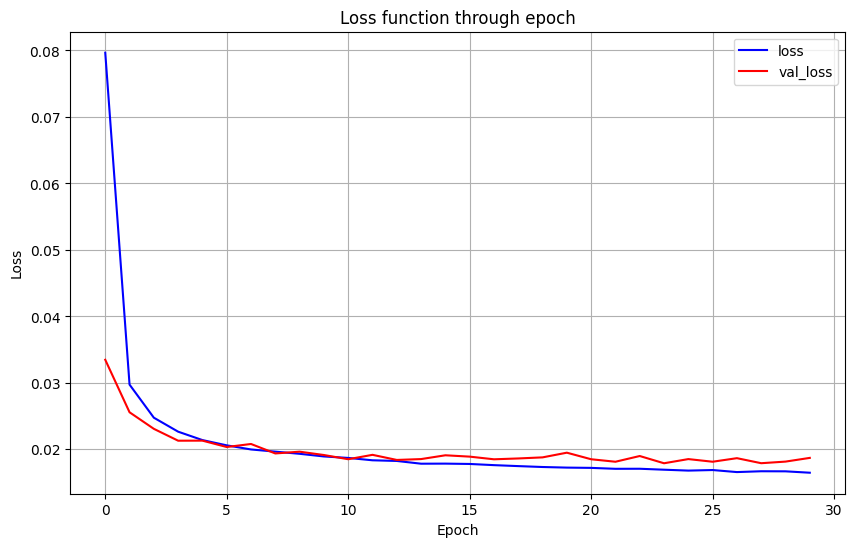

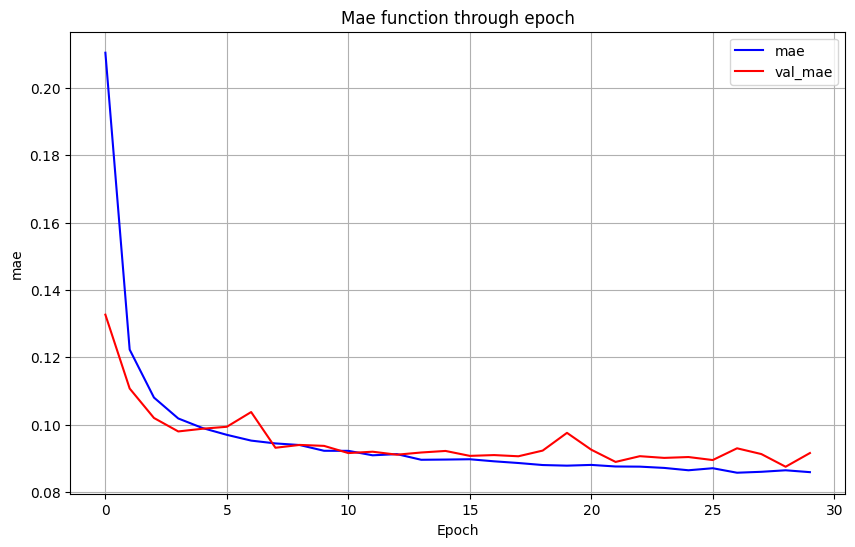

C:\Users\lovoa\AppData\Local\Temp\ipykernel_12568\250368514.py:83: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


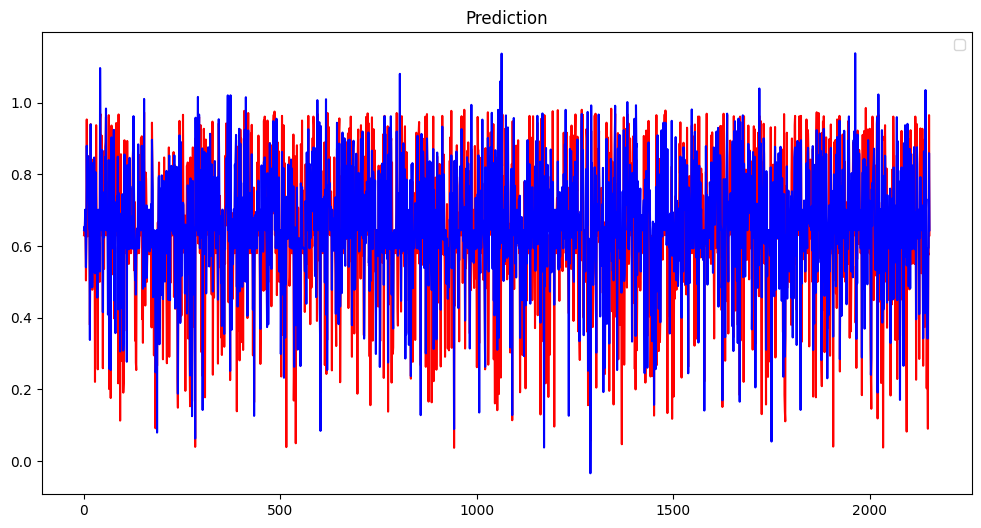

MSE


0.018719402268217184

Epoch 1/30


c:\Users\lovoa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1288 - mae: 0.2761 - val_loss: 0.0509 - val_mae: 0.1813
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0511 - mae: 0.1777 - val_loss: 0.0403 - val_mae: 0.1623
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0403 - mae: 0.1589 - val_loss: 0.0359 - val_mae: 0.1526
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0348 - mae: 0.1457 - val_loss: 0.0331 - val_mae: 0.1463
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0330 - mae: 0.1423 - val_loss: 0.0317 - val_mae: 0.1425
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0324 - mae: 0.1423 - val_loss: 0.0302 - val_mae: 0.1399
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0304 - mae: 0.1381 - val_loss: 0.0297 - val_mae: 0.1380
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0286 - mae: 0.1336 - val_loss: 0.0291 - val_mae: 0.1362
Epoch 9/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0267 - mae: 0.1309 - va

,Song,Performer,valence
SongID,,,
(I've Got) BonnieBobby Rydell,(I've Got) Bonnie,Bobby Rydell,0.698
(The Man Who Shot) Liberty ValanceGene Pitney,(The Man Who Shot) Liberty Valance,Gene Pitney,0.837
(There's) Always Something There To Remind MeDionne Warwick,(There's) Always Something There To Remind Me,Dionne Warwick,0.821
"4, 5, 6Sole Featuring JT Money & Kandi","4, 5, 6",Sole Featuring JT Money & Kandi,0.762
5 O'ClockNonchalant,5 O'Clock,Nonchalant,0.800
...,...,...,...
Don't Come Out The HouseMetro Boomin Featuring 21 Savage,Don't Come Out The House,Metro Boomin Featuring 21 Savage,0.175
Don't Cry No MoreBobby Bland,Don't Cry No More,Bobby Bland,0.890
Don't Cry Out LoudMelissa Manchester,Don't Cry Out Loud,Melissa Manchester,0.278


-----------------------------------------------------
---------------------------------------------------------
USER 3


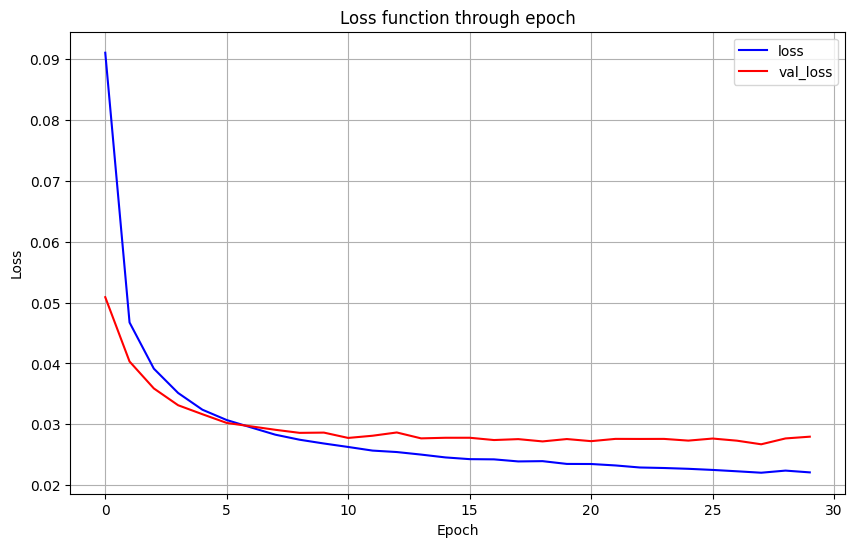

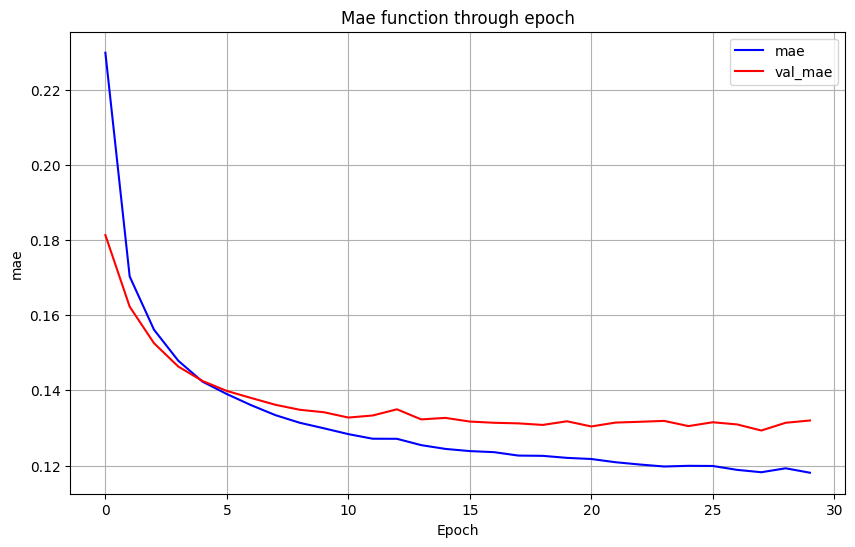

C:\Users\lovoa\AppData\Local\Temp\ipykernel_12568\250368514.py:83: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


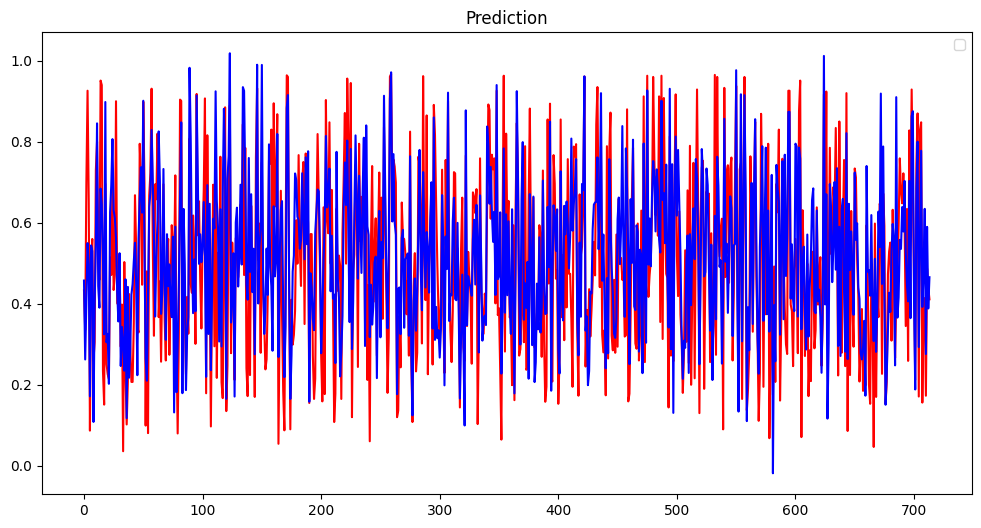

MSE


0.027977699404137954

c:\Users\lovoa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2488 - mae: 0.3899 - val_loss: 0.0994 - val_mae: 0.2536
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0811 - mae: 0.2271 - val_loss: 0.0648 - val_mae: 0.2009
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0525 - mae: 0.1836 - val_loss: 0.0515 - val_mae: 0.1776
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0447 - mae: 0.1676 - val_loss: 0.0457 - val_mae: 0.1684
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0400 - mae: 0.1613 - val_loss: 0.0404 - val_mae: 0.1583
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0369 - mae: 0.1536 - val_loss: 0.0387 - val_mae: 0.1555
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0352 - mae: 0.1508 - val_loss: 0.0373 - val_mae: 0.1515
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0334 - mae: 0.1471 - val_loss: 0.0348 - val_mae: 0.1461
Epoch 9/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0325 - mae: 

,Song,Performer,valence
SongID,,,
'TilThe Angels,'Til,The Angels,0.307
(if You Add) All The Love In The WorldMac Davis,(if You Add) All The Love In The World,Mac Davis,0.359
(Sittin' On) The Dock Of The BayMichael Bolton,(Sittin' On) The Dock Of The Bay,Michael Bolton,0.565
(There's) No Gettin' Over MeRonnie Milsap,(There's) No Gettin' Over Me,Ronnie Milsap,0.787
(You're My) Soul And InspirationThe Righteous Brothers,(You're My) Soul And Inspiration,The Righteous Brothers,0.277
...,...,...,...
Don't Give Up On UsDavid Soul,Don't Give Up On Us,David Soul,0.415
Don't Let GoCommander Cody,Don't Let Go,Commander Cody,0.867
Don't Look BackThe Temptations,Don't Look Back,The Temptations,0.902


-----------------------------------------------------
---------------------------------------------------------
USER 4


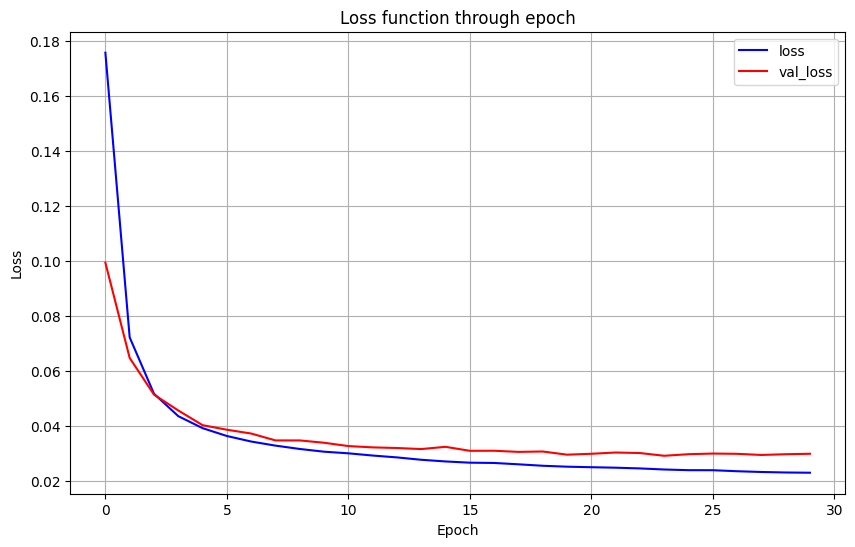

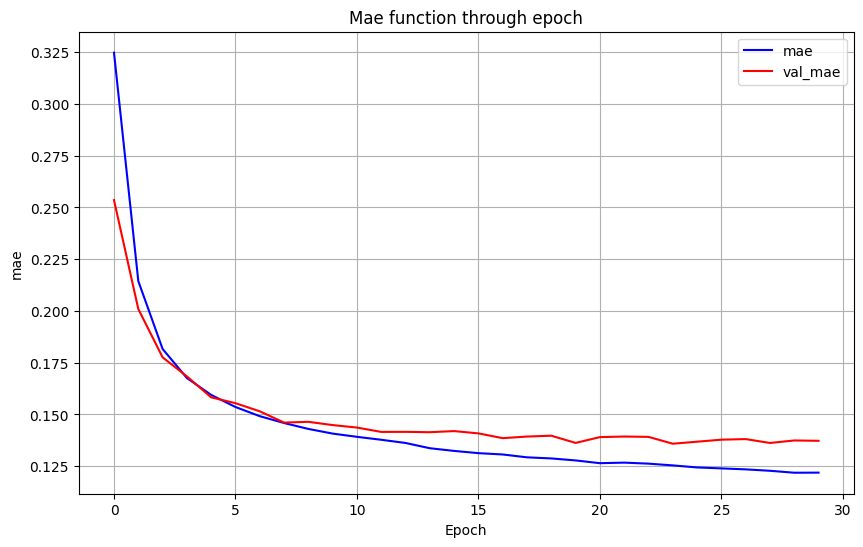

C:\Users\lovoa\AppData\Local\Temp\ipykernel_12568\250368514.py:83: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


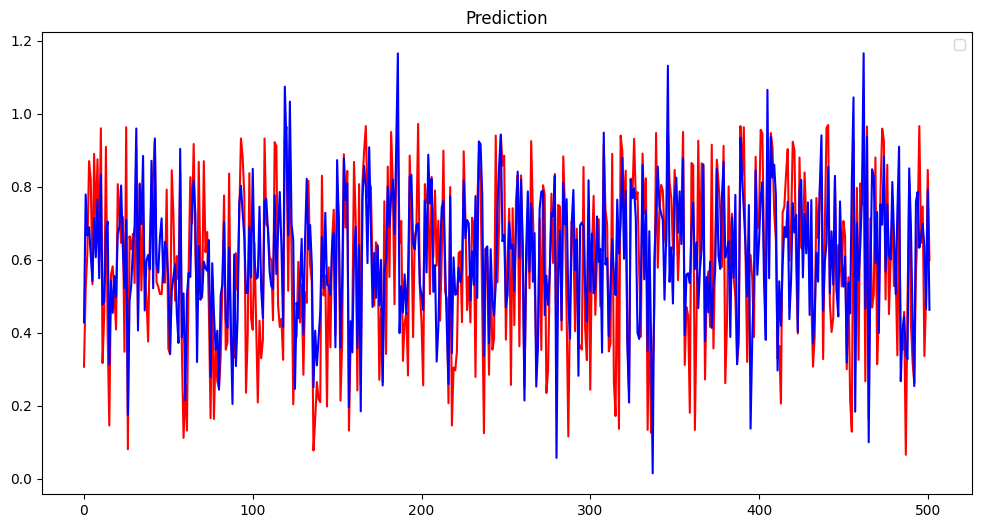

MSE


0.029970654442997652

In [20]:
dizio_model_user = {} #in this dizio we store the model for each user

# DICTIONARY TO STORE SONG RECOMMENDATION PER USER
reccomandations_songs_per_user={}

#loop creation user and model
for i in range(0, len(merge_unique_numain_df['User'].unique())): #i indica lo user   

    #select user
    mask_user = merge_unique_numain_df['User'] == i
    #display(mask_user)
    user_i_df = merge_unique_numain_df[mask_user]
    #display(user_i_df) 

    #extract the feature and target
    x = user_i_df[features]
    y = user_i_df[target]

    #normalization
    x_scaled = StandardScaler().fit_transform(x)


    ######################
    ## CROSS VALIDATION ##
    ######################
    
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    '''
    #split; serve farlo? non se ne occupa il fit? chiedere
    x_train,x_test,y_train,y_test=train_test_split(x_scaled,y,test_size=0.2,random_state=42)
    #display(x_train)
    '''
    
    #################
    ## TRAIN/SPLIT ##
    #################

    for train_index, val_index in kf.split(x_scaled):
        x_train, x_test = x_scaled[train_index], x_scaled[val_index]
        y_train, y_test = y.iloc[train_index], y.iloc[val_index]

    #conversion
    y_train=np.array(y_train)
    y_test=np.array(y_test)

    #creation model for the specific user
    model_user_i = create_model_user(x_train.shape[1])
    
    #fit the model with the different x, y train (for different user)
    history_model_user_i = fit_model(model_user_i, x_train, y_train, x_test, y_test)

    #test no function
    '''history_model_user_i = model_user_i.fit(
        x_train,y_train,
        #validation_split=0.2,
        validation_data = [x_test, y_test],
        epochs=30,
        batch_size=32,
        #verbose=1
    )'''

    # AGGIUNTO A.L.
    #y_hat=model_user_i.predict(x_train)
    y_hat = model_user_i.predict(x_test)

    ###################################
    ###################################
    # AGGIUNTO A.L. --> RECOMANDATION #
    ###################################
    ###################################

    #in order to have indices match between y_hat and x_test
    x_test_indices=user_i_df.iloc[np.arange(len(y_hat))].index
    # Threshold for raccommendations --> valence > 0.7
    reccomended_songs=user_i_df.loc[x_test_indices][y_hat.flatten()>0.7] # filtet songs with valence > 0.7

    # in order to visualize reccomandation
    print(f'\nReccomendations for User{i}:')
    if reccomended_songs.empty:
        print('No songs recommended based on valence threshold')
    else:
        display(reccomended_songs[['Song','Performer','valence']])

    # Now we want to save recommendation in dictionary
    reccomandations_songs_per_user['User{i}']=reccomended_songs

    #QUALCOSA NON QUADRA --> AGGIUNGE AL DIZIONARIO ANCHE CANZONI CON VALENCE > 0.7

    print('-----------------------------------------------------')

    #plot the metrics of the model
    print('---------------------------------------------------------')
    print(f'USER {i}')
    plot_for_model(history_model_user_i, y_hat, x_test)

    #compute MSE
    print('MSE')
    mse = mean_squared_error(y_test, y_hat)
    display(mse)

    #save the model in the dictionary
    #add also the raccomandations
    dizio_model_user[f"User{i}"] = {'model_user_i' : model_user_i,
                                    'history_model_user_i': history_model_user_i,
                                    'x_train': x_train,
                                    'x_test': x_test,
                                    'y_train': y_train,
                                    'y_test': y_test,
                                    'y_hat': y_hat,
                                    'recommendations:': reccomended_songs} 


## CONCLUSION 

Controllare anche qui i risultati rispetto alle altre 2 NN

--> ho fatto un file con tutti i risultati a confronto 


